# Computational control - Bonus Tutorial:
# Data-enabled Predictive Control (DeePC) and the Projection Regularizer

This tutorial examines two different regularizers for DeePC algorithm--the "Standard Regularizer," and the "Projection Regularizer."

Additional insight can be found in Prof. Dörfler's paper, [Bridging direct & indirect data-driven control formulations via regularizations and relaxations](https://arxiv.org/pdf/2101.01273).

As with the tutorial that introduced DeePC, we will look at a standard double integrator system.

### Package imports

In [11]:
import numpy as np                         # For linear algebra
import cvxpy as cp                         # For optimization
import matplotlib.pyplot as plt            # For plots
from scipy.linalg import svdvals           # For computing singular values
np.set_printoptions(precision=3)           # Set nice printing format

Double Integrator System

In [12]:
dt = .1
mass = 1

A = np.array([[1, dt],
              [0, 1]])
B = np.array([[(dt/mass)**2/2],
              [dt/mass]])
C = np.array([[1, 0]])

# System constants
n = np.shape(A)[0] # state dimension
m = np.shape(B)[1] # input dimension
p = np.shape(C)[0] # output dimension

**Gather data**

The code below gathers data and investigates the impact of noise on the singular values of the Hankel matrix.

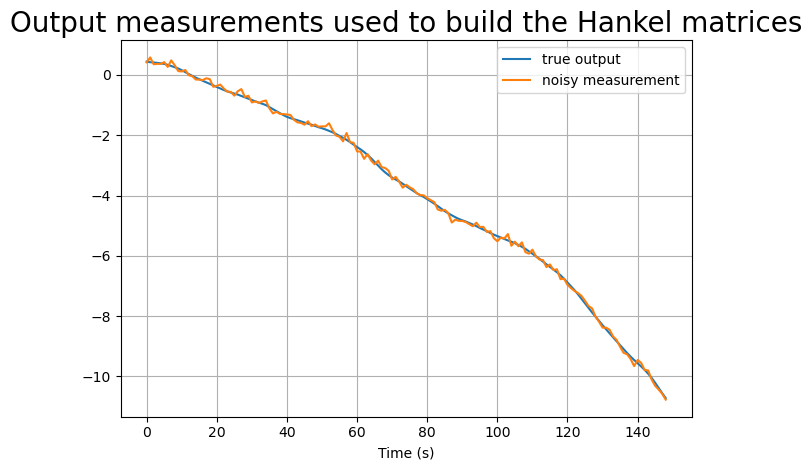

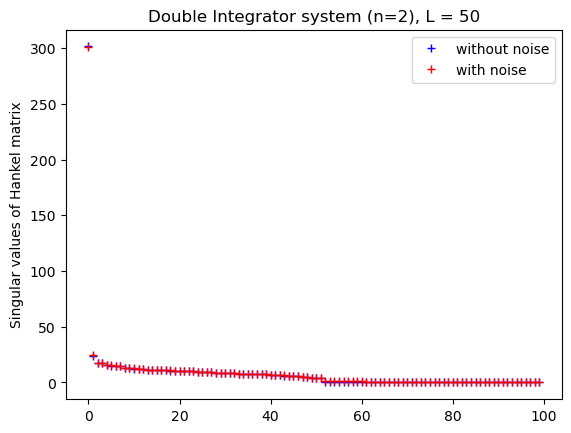

In [13]:
np.random.seed(5) # for debugging. You can set the random seed so that there is not variance between runs. This may or may not be useful.

# Set Hankel dimensions
T_past = 20 # T_past is the number of timesteps into the past that the DeePC optimization considers.
T_fut = 30 # T_future is the number of timesteps into the future that the DeePC optimization plans for.
L = T_past+T_fut

T_hankel = 3*L-1 # T_hankel is the number of data points used to build the Hankel matrix
# (3*L-1 is an arbitrary choice, and not optimal)

s_noise = 0.1 # the standard deviation of the output measurement

# Collect data
x_data = np.zeros((T_hankel+1,2))
u_data = np.zeros((T_hankel,1))
y_data = np.zeros((T_hankel,1))
y_data_noisy = np.zeros((T_hankel,1))

x_data[0] = np.reshape(np.random.randn(n,1),n)*1 # initial condition

s_input = 1 # the standard deviation of the gaussian excitation used to perturb the system to gather persistently-excited data

# Gather data
for i in range(T_hankel):
    u_data[i] = np.random.randn(1)*s_input
    x_data[i+1] = A@x_data[i] + B@u_data[i]
    y_data[i] = C@x_data[i]
    y_data_noisy[i] = C@x_data[i] + np.random.randn(p,1)*s_noise

plt.plot(range(0,T_hankel), y_data, label='true output')
plt.plot(range(0,T_hankel), y_data_noisy, label='noisy measurement')
plt.xlabel('Time (s)')
plt.title("Output measurements used to build the Hankel matrices", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.show()

# Build Hankel matrices
num_hankel_cols = T_hankel - L
H_u = u_data[:L]
H_y = y_data[:L]
H_y_noisy = y_data_noisy[:L]

for i in range(num_hankel_cols):
    H_u = np.hstack((H_u,u_data[i:i+L]))
    H_y = np.hstack((H_y,y_data[i:i+L]))
    H_y_noisy = np.hstack((H_y_noisy,y_data_noisy[i:i+L]))

H = np.vstack((H_u,H_y))

# Calculate the singular values for comparison
singular_values = svdvals(H)
rank_hankel = np.linalg.matrix_rank(H)

H_noisy = np.vstack((H_u,H_y_noisy))
singular_values_noisy = svdvals(H_noisy)
rank_hankel_noisy = np.linalg.matrix_rank(H_noisy)

plt.plot(singular_values,'b+',label='without noise')
plt.plot(singular_values_noisy,'r+',label='with noise')
plt.ylabel('Singular values of Hankel matrix')
plt.title(f'Double Integrator system (n=2), L = {L}')
plt.legend()
plt.show()

**Question**

When there is no noise in the data, what is the rank of the Hankel matrix? What expression (using the quantities given) explains the rank of the Hankel matrix?


**Question**

When there is noise in the data, what is the rank of the Hankel matrix?



**Define the DeePC controller**

In [14]:
class DeePCcontrollerClass:
    def __init__(self, T_hankel, T_past, T_fut, r, q, lam_g_stan, lam_g_proj, lam_sigma, H_u, H_y, solver):

        self.solver = solver

        self.T_hankel = T_hankel
        self.T_past = T_past
        self.T_fut = T_fut
        self.L = self.T_past + self.T_fut

        self.r = r # input cost weight
        self.q = q # output ~
        self.lam_g_stan = lam_g_stan # weight for the Standard g regularization
        self.lam_g_proj = lam_g_proj # weight for the Projection g regularization
        self.lam_sigma = lam_sigma # weight for the sigma regularization  (usually large works well)

        # offline data
        self.H_u = H_u
        self.H_y = H_y

        if self.lam_g_proj != 0:
            H = np.vstack((self.H_u, self.H_y[:p*T_past]))
            Pi = np.linalg.pinv(H)@H
            I = np.eye(Pi.shape[0])
            self.HkernelProjMat = I - Pi


    def step(self, u_p, y_p, y_ref):
        """
        Returns the first action of input sequence.
        """
        verbose=False

        # set up the DeePC optimization in CVX
        # Helpful CVX functions: cp.Variable(), cp.quad_form()

        g = cp.Variable(self.T_hankel - self.L +1)
        u_f = cp.Variable(self.T_fut)
        y_f = cp.Variable(self.T_fut)
        sigma = cp.Variable(self.T_past)

        if self.lam_g_proj == 0:
            cost = self.q*cp.quad_form(y_f-y_ref, np.eye(T_fut)) + self.r*cp.quad_form(u_f, np.eye(T_fut)) + self.lam_g_stan*cp.atoms.norm(g,1) + self.lam_sigma*cp.atoms.norm(sigma,2)
        else:
            cost = self.q*cp.quad_form(y_f-y_ref, np.eye(T_fut)) + self.r*cp.quad_form(u_f, np.eye(T_fut)) + self.lam_g_stan*cp.atoms.norm(g,1) + self.lam_g_proj*cp.sum_squares(self.HkernelProjMat@g) + self.lam_sigma*cp.atoms.norm(sigma,2)

        U_p = self.H_u[:m*T_past]
        U_f = self.H_u[m*T_past:]
        Y_p = self.H_y[:p*T_past]
        Y_f = self.H_y[p*T_past:]

        constraints = [
            U_p@g == u_p,
            U_f@g == u_f,
            Y_p@g == y_p + sigma,
            Y_f@g == y_f
        ]

        prob = cp.Problem(cp.Minimize(cost), constraints)
        if self.solver is None:
            prob.solve(verbose=False)
        else:
            prob.solve(verbose=False, solver=self.solver)
        if prob.status not in ['optimal', 'optimal_inaccurate']:
            raise Exception(f'cvx had an issue with the optimization. got prob.status: {prob.status}')

        return u_f.value, y_f.value, g.value, sigma.value

**Set the DeePC Controller Hyperparameters**

These hyperparameters need to be tuned in order for DeePC to work.

The weights below were chose relatively arbitrarily. You can improve performance by optimizing the weights.

In [15]:
# Cost function hyperparameters
r = 0.0001 # this is input cost weight in the DeePC optimization
q = 10 # output ~

# Regularization hyperparameters
lam_sigma = 100 # weight for the sigma regularization
lam_g_stan = 10 # weight for the Standard g regularization
lam_g_proj = 10000 # weight for the Projection g regularization

#solver = cp.MOSEK # the solver/optimization engine can also be thought of as a hyperparameter. In general, Mosek works pretty well for DeePC. You might investigate other solvers as well if you are having convergence issues, or try different hyperparameters.
# solver = cp.ECOS # this is another solver option for cvx.
solver = None # this uses cvx's default solver

# (T_past and T_fut could also be thought of as hyperparameters, but they have already been set above)

**Installing MOSEK (optional)**

If you choose to use Mosek, you need to provide an academic license, which can be acquired from Mosek's [website](https://www.mosek.com/products/academic-licenses/). In JupyterHub, a Mosek license should already be available.

In [16]:
if solver == cp.MOSEK:
    #installs mosek
    !pip install mosek

    import os

    #connect google drive
    from google.colab import drive
    drive.mount('/content/drive')

    #give the path to your mosek license--this file is given to you after you sign up for mosek
    #after getting the license, you have to put the .lic file in your google drive in the location [gdrive_path_forMosekLic]
    gdrive_path_forMosekLic = "/content/drive/MyDrive/ColabNotebooks/mosek/mosek.lic"

    #this makes a directory for mosek in the google drive root folder and copies the license which was put in the google drive above
    !mkdir 'mosek'
    !cp "/content/drive/MyDrive/Colab Notebooks/mosek/mosek.lic" 'mosek'
    !ls # this should now include a folder called mosek
    !ls 'mosek' # this should now include a file called mosek.lic

    os.environ['MOSEKLM_LICENSE_FILE']="/content/mosek" # this changes where Mosek looks for the license from ":/root/mosek" to "/content/mosek".
    # /content is the root folder for google colab, not :/root

**Build the DeePC controller**

In [17]:
DeePCcontroller = DeePCcontrollerClass(T_hankel, T_past, T_fut, r, q, lam_g_stan, lam_g_proj, lam_sigma, H_u, H_y_noisy, solver)

**DeePC evaluation simulation settings**

In [18]:
T_sim = 200 #simulation time steps
y_reference = 2 # output reference
x_0 = np.zeros(n) # Initial state

**DeePC evaluation simulation**

In [19]:
u_sim = np.zeros((T_sim, 1))
x_sim = np.zeros((T_sim+1, n))
y_sim = np.zeros((T_sim, 1))
y_reference_sim = np.ones((T_sim, p*T_fut))*y_reference

u_p_sim = np.zeros(T_past)
y_p_sim = np.zeros(T_past)

x_sim[0] = x_0

for i in range(T_sim):
      # Get the control action using DeePCcontroller.step()
      if i == 0:  # store first open-loop prediction in uy_fut
        u_fut_start, y_fut_start, g_start, _ = DeePCcontroller.step(u_p_sim, y_p_sim, y_reference_sim[i])
        u_fut = u_fut_start
      else:
        u_fut = DeePCcontroller.step(u_p_sim, y_p_sim, y_reference_sim[i])[0]

      u_next = u_fut[0]

      u_sim[i] = u_next

      #siulate one step
      x_sim[i+1] = A@x_sim[i] + B@u_sim[i]
      y_sim[i] = C@x_sim[i]

      # Update u_p_sim and y_p_sim
      u_p_sim = np.append(u_p_sim[1:], u_sim[i])
      y_p_sim = np.append(y_p_sim[1:], y_sim[i])

print('Simulation complete')


thread '<unnamed>' panicked at /root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/gemm-f64-0.18.2/src/gemm.rs:3:5:
called `Option::unwrap()` on a `None` value


PanicException: called `Option::unwrap()` on a `None` value

**Plot results**

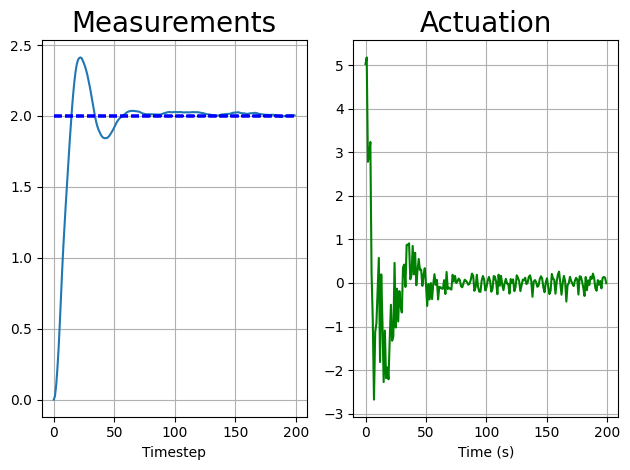

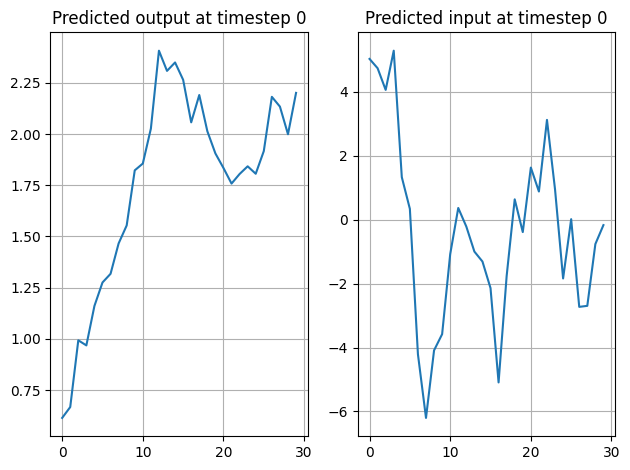

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(0,T_sim), y_sim)
plt.plot(range(0,T_sim), y_reference_sim, 'b--')
plt.xlabel('Timestep')
plt.title("Measurements", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T_sim), u_sim, 'g')
plt.xlabel('Time (s)')
plt.title("Actuation", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.show()

plt.subplot(1,2,1)
plt.plot(range(T_fut),y_fut_start)
plt.title("Predicted output at timestep 0")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(T_fut),u_fut_start)
plt.title("Predicted input at timestep 0")
plt.grid('on')
plt.tight_layout()

plt.show()